# Analisis Voice (Audio) menggunakan TSFEL 

**Feature extraction audio (voice)** dengan [TSFEL] untuk klasifikasi suara "buka" dan "tutup"

## 0) Persiapan lingkungan (install & import)

In [2]:
!pip install streamlit streamlit-webrtc audio-recorder-streamlit tsfel librosa soundfile numpy pandas matplotlib scikit-learn scipy pydub av joblib tqdm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio utils
import soundfile as sf  # baca/tulis wav
import librosa          # pemrosesan audio
import librosa.display

# TSFEL
import tsfel

## 1) Muat semua file audio dari folder buka dan tutup

Loading 100 file dari folder 'buka'...


Loading 100 file dari folder 'tutup'...

Total audio loaded: 200
Buka: 100, Tutup: 100
Sampling rate: 16000 Hz


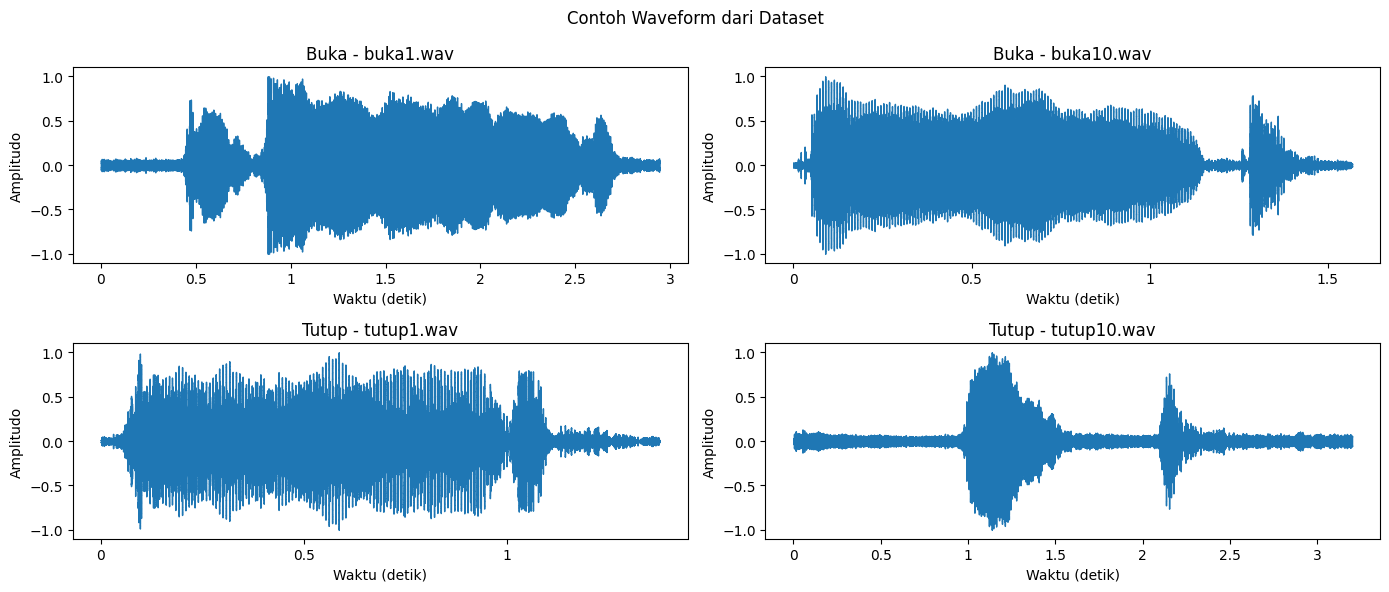

In [4]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path

# === PATH KE DATASET ===
BASE_PATH = "/workspaces/PSD/PSD/Data/voice_augmented"
BUKA_PATH = os.path.join(BASE_PATH, "buka")
TUTUP_PATH = os.path.join(BASE_PATH, "tutup")

# Parameter sampling
TARGET_SR = 16000  # 16 kHz umum untuk analisis speech

# === Fungsi untuk memuat dan preprocess audio ===
def load_audio_file(file_path, sr=16000):
    """Memuat file audio, trim silence, dan normalisasi"""
    try:
        y, sample_rate = librosa.load(file_path, sr=sr, mono=True)
        # Trim silence di awal/akhir
        y_trimmed, _ = librosa.effects.trim(y, top_db=25)
        # Normalisasi amplitudo
        if np.max(np.abs(y_trimmed)) > 0:
            y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))
        return y_trimmed, sample_rate
    except Exception as e:
        print(f"⚠️ Gagal memuat {file_path}: {e}")
        return None, None

# === Kumpulkan semua file audio ===
audio_data, labels, filenames = [], [], []

# Load file dari folder 'buka'
buka_files = sorted([f for f in os.listdir(BUKA_PATH) if f.endswith('.wav')])
print(f"Loading {len(buka_files)} file dari folder 'buka'...")
for file in buka_files:
    file_path = os.path.join(BUKA_PATH, file)
    y, sr = load_audio_file(file_path, TARGET_SR)
    if y is not None:
        audio_data.append(y)
        labels.append(0)  # Label 0 untuk "buka"
        filenames.append(file)

# Load file dari folder 'tutup'
tutup_files = sorted([f for f in os.listdir(TUTUP_PATH) if f.endswith('.wav')])
print(f"Loading {len(tutup_files)} file dari folder 'tutup'...")
for file in tutup_files:
    file_path = os.path.join(TUTUP_PATH, file)
    y, sr = load_audio_file(file_path, TARGET_SR)
    if y is not None:
        audio_data.append(y)
        labels.append(1)  # Label 1 untuk "tutup"
        filenames.append(file)

print(f"\nTotal audio loaded: {len(audio_data)}")
print(f"Buka: {labels.count(0)}, Tutup: {labels.count(1)}")
print(f"Sampling rate: {TARGET_SR} Hz")

# === Visualisasi beberapa contoh waveform ===
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
fig.suptitle('Contoh Waveform dari Dataset')

# Plot 2 contoh dari "buka"
for i in range(2):
    if i < len(audio_data):
        librosa.display.waveshow(audio_data[i], sr=TARGET_SR, ax=axes[0, i])
        axes[0, i].set_title(f'Buka - {filenames[i]}')
        axes[0, i].set_xlabel('Waktu (detik)')
        axes[0, i].set_ylabel('Amplitudo')

# Plot 2 contoh dari "tutup"
buka_count = labels.count(0)
for i in range(2):
    idx = buka_count + i
    if idx < len(audio_data):
        librosa.display.waveshow(audio_data[idx], sr=TARGET_SR, ax=axes[1, i])
        axes[1, i].set_title(f'Tutup - {filenames[idx]}')
        axes[1, i].set_xlabel('Waktu (detik)')
        axes[1, i].set_ylabel('Amplitudo')

plt.tight_layout()
plt.show()


## 2) Analisis durasi audio dan statistik dasar

Statistik Durasi Audio (detik):
Buka  - Mean: 1.801, Std: 1.058, Min: 0.448, Max: 3.867
Tutup - Mean: 1.778, Std: 0.802, Min: 0.448, Max: 3.904


/tmp/ipykernel_2240/3803697676.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([durations_buka, durations_tutup], labels=['Buka', 'Tutup'])


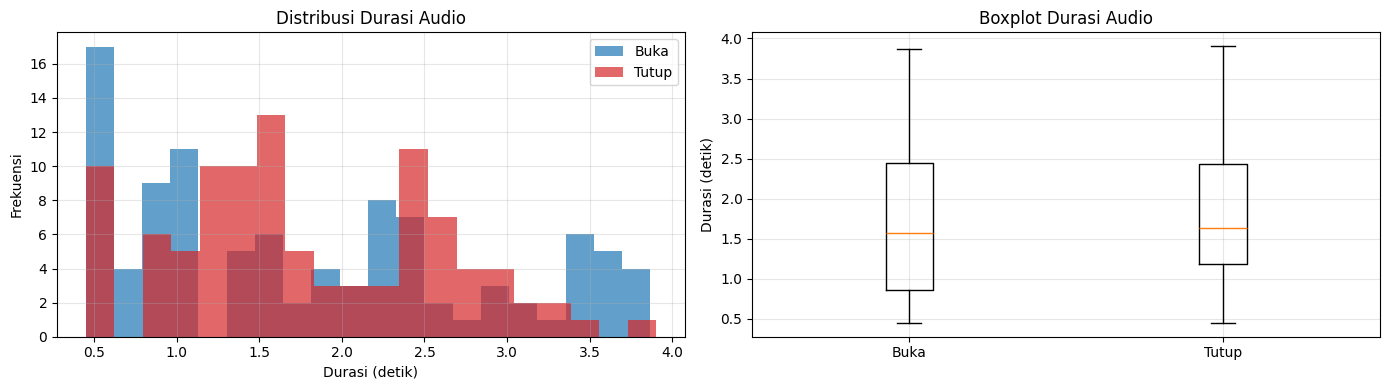

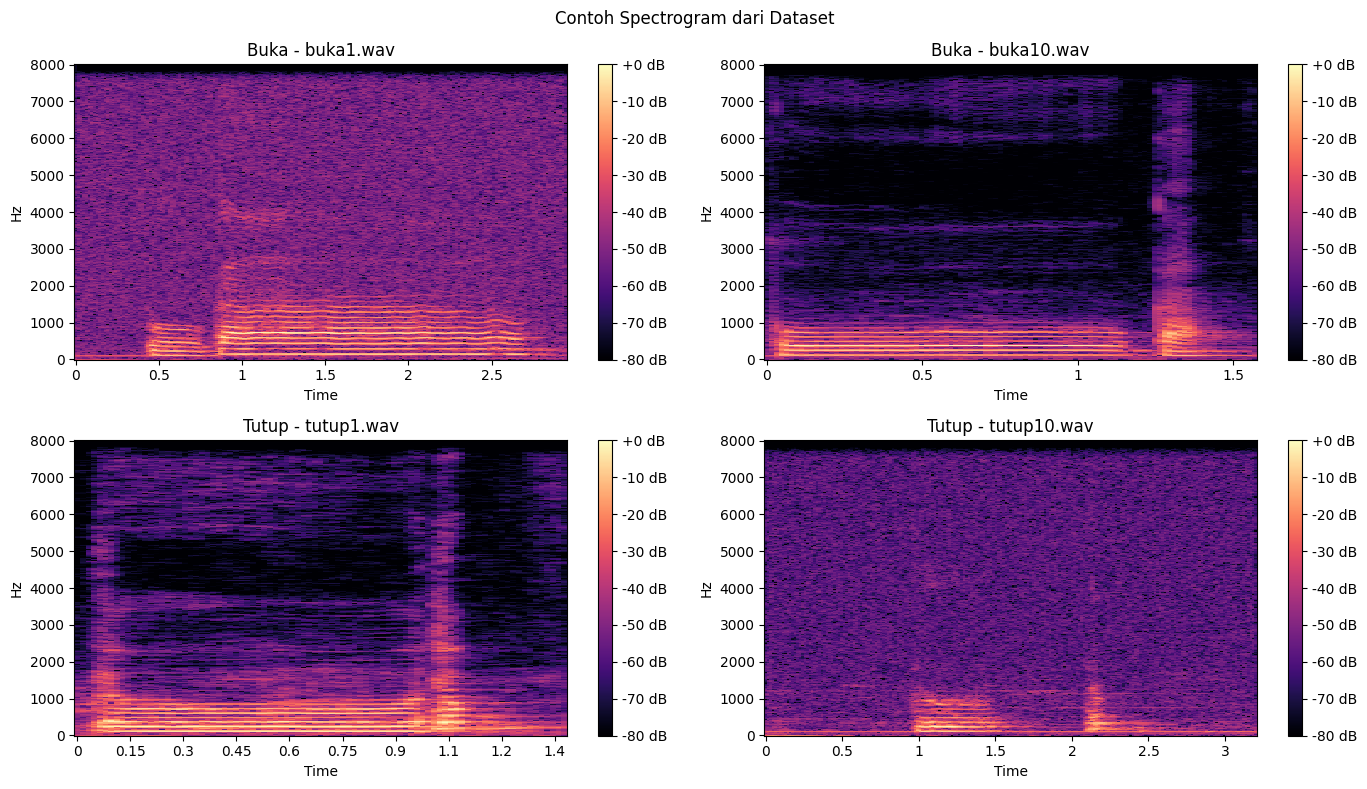

In [5]:
# ==========================================================
# ANALISIS DURASI AUDIO & VISUALISASI SPEKTRUM
# ==========================================================

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Analisis durasi audio
durations = [len(y) / TARGET_SR for y in audio_data]
durations_buka = [d for d, l in zip(durations, labels) if l == 0]
durations_tutup = [d for d, l in zip(durations, labels) if l == 1]

# Statistik durasi
print("Statistik Durasi Audio (detik):")
if durations_buka:
    print(f"Buka  - Mean: {np.mean(durations_buka):.3f}, Std: {np.std(durations_buka):.3f}, Min: {np.min(durations_buka):.3f}, Max: {np.max(durations_buka):.3f}")
if durations_tutup:
    print(f"Tutup - Mean: {np.mean(durations_tutup):.3f}, Std: {np.std(durations_tutup):.3f}, Min: {np.min(durations_tutup):.3f}, Max: {np.max(durations_tutup):.3f}")

# ==========================================================
# VISUALISASI DISTRIBUSI DURASI
# ==========================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(durations_buka, bins=20, alpha=0.7, label='Buka', color='tab:blue')
axes[0].hist(durations_tutup, bins=20, alpha=0.7, label='Tutup', color='tab:red')
axes[0].set_xlabel('Durasi (detik)')
axes[0].set_ylabel('Frekuensi')
axes[0].set_title('Distribusi Durasi Audio')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot([durations_buka, durations_tutup], labels=['Buka', 'Tutup'])
axes[1].set_ylabel('Durasi (detik)')
axes[1].set_title('Boxplot Durasi Audio')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================================
# VISUALISASI SPECTROGRAM
# ==========================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Contoh Spectrogram dari Dataset')

# 2 contoh "buka"
for i in range(2):
    if i < len(audio_data):
        try:
            S = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data[i], n_fft=1024, hop_length=256)), ref=np.max)
            img = librosa.display.specshow(S, sr=TARGET_SR, hop_length=256, x_axis='time', y_axis='linear', ax=axes[0, i])
            axes[0, i].set_title(f'Buka - {filenames[i]}')
            fig.colorbar(img, ax=axes[0, i], format='%+2.0f dB')
        except Exception as e:
            axes[0, i].text(0.5, 0.5, f"Gagal plot {filenames[i]}\n{e}", ha='center', va='center', transform=axes[0, i].transAxes)

# 2 contoh "tutup"
buka_count = labels.count(0)
for i in range(2):
    idx = buka_count + i
    if idx < len(audio_data):
        try:
            S = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data[idx], n_fft=1024, hop_length=256)), ref=np.max)
            img = librosa.display.specshow(S, sr=TARGET_SR, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1, i])
            axes[1, i].set_title(f'Tutup - {filenames[idx]}')
            fig.colorbar(img, ax=axes[1, i], format='%+2.0f dB')
        except Exception as e:
            axes[1, i].text(0.5, 0.5, f"Gagal plot {filenames[idx]}\n{e}", ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.show()


## 3) Konfigurasi fitur TSFEL

In [6]:
import tsfel
import librosa
import numpy as np
import pandas as pd

cfg = tsfel.get_features_by_domain(["statistical"])

# Cek jumlah fitur
n_feats = tsfel.get_number_features(cfg)
print("="*60)
print(f"Jumlah fitur TSFEL yang akan diekstrak: {n_feats}")
print("="*60)
print("Domain yang digunakan:", list(cfg.keys()))


Jumlah fitur TSFEL yang akan diekstrak: 31
Domain yang digunakan: ['statistical']


## 4) Ekstraksi fitur TSFEL untuk semua audio

Kita akan mengekstrak fitur untuk setiap file audio menggunakan TSFEL.
Strategi: Ekstrak fitur dari **seluruh sinyal** (full-signal) untuk setiap file audio, sehingga setiap file akan menghasilkan satu vektor fitur.

In [7]:
from tqdm import tqdm

def extract_mfcc_features(y, sr, n_mfcc=13):
    """
    Ekstrak fitur MFCC dan statistiknya (mean, std, delta)
    """
    try:
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta_mean = np.mean(mfcc_delta, axis=1)

        features = np.hstack([mfcc_mean, mfcc_std, mfcc_delta_mean])
        feature_names = (
            [f"mfcc_mean_{i+1}" for i in range(n_mfcc)] +
            [f"mfcc_std_{i+1}" for i in range(n_mfcc)] +
            [f"mfcc_delta_mean_{i+1}" for i in range(n_mfcc)]
        )
        return features, feature_names
    except Exception as e:
        print(f"⚠️ Gagal ekstrak MFCC: {e}")
        return np.full(3*n_mfcc, np.nan), [f"mfcc_{i+1}" for i in range(3*n_mfcc)]


# ==========================================================
# EKSTRAKSI FITUR TSFEL + MFCC
# ==========================================================
print("🔍 Mengekstrak fitur TSFEL + MFCC untuk setiap file audio...")

features_list = []
valid_filenames = []
valid_labels = []

for i, (y, label, fname) in tqdm(enumerate(zip(audio_data, labels, filenames)), total=len(audio_data), ncols=80):
    try:
        # --- TSFEL features ---
        X_tsfel = tsfel.time_series_features_extractor(cfg, y, fs=TARGET_SR, window_size=256, verbose=0)
        tsfel_feats = X_tsfel.iloc[0].values

        # --- MFCC features ---
        mfcc_feats, mfcc_names = extract_mfcc_features(y, TARGET_SR)

        # Gabungkan keduanya
        all_features = np.concatenate([tsfel_feats, mfcc_feats])
        features_list.append(all_features)
        valid_filenames.append(fname)
        valid_labels.append(label)

    except Exception as e:
        print(f"⚠️ Error pada file {fname}: {str(e)}")
        features_list.append(np.full(n_feats + len(mfcc_names), np.nan))
        valid_filenames.append(fname)
        valid_labels.append(label)

print(f"\n✅ Ekstraksi fitur selesai untuk {len(features_list)} file audio.")

# ==========================================================
# BUAT DATAFRAME FITUR GABUNGAN
# ==========================================================
feature_names_tsfel = list(X_tsfel.columns)
feature_names_all = feature_names_tsfel + mfcc_names

X_all = pd.DataFrame(features_list, columns=feature_names_all)
X_all['label'] = valid_labels
X_all['filename'] = valid_filenames

print(f"\nShape fitur gabungan: {X_all.shape}")
print(f"Fitur total: {X_all.shape[1] - 2} features + label + filename")
X_all.head()


🔍 Mengekstrak fitur TSFEL + MFCC untuk setiap file audio...


  0%|                                                   | 0/200 [00:00<?, ?it/s]

  0%|▏                                          | 1/200 [00:05<19:08,  5.77s/it]

  1%|▍                                          | 2/200 [00:09<15:10,  4.60s/it]

  2%|▋                                          | 3/200 [00:12<12:59,  3.95s/it]

  2%|▊                                          | 4/200 [00:16<12:57,  3.96s/it]

  2%|█                                          | 5/200 [00:20<13:00,  4.00s/it]

  3%|█▎                                         | 6/200 [00:24<12:43,  3.93s/it]

  4%|█▌                                         | 7/200 [00:28<12:11,  3.79s/it]

  4%|█▋                                         | 8/200 [00:31<12:12,  3.81s/it]

  4%|█▉                                         | 9/200 [00:36<12:35,  3.96s/it]

  5%|██                                        | 10/200 [00:39<12:01,  3.80s/it]

  6%|██▎                                       | 11/200 [00:43<11:58,  3.80s/it]

  6%|██▌                                       | 12/200 [00:47<11:47,  3.76s/it]

  6%|██▋                                       | 13/200 [00:50<11:29,  3.69s/it]

  7%|██▉                                       | 14/200 [00:54<11:34,  3.74s/it]

  8%|███▏                                      | 15/200 [00:57<11:14,  3.65s/it]

  8%|███▎                                      | 16/200 [01:01<11:05,  3.61s/it]

  8%|███▌                                      | 17/200 [01:04<10:48,  3.54s/it]

  9%|███▊                                      | 18/200 [01:08<10:41,  3.53s/it]

 10%|███▉                                      | 19/200 [01:12<10:45,  3.57s/it]

 10%|████▏                                     | 20/200 [01:15<10:43,  3.58s/it]

 10%|████▍                                     | 21/200 [01:19<10:58,  3.68s/it]

 11%|████▌                                     | 22/200 [01:23<10:53,  3.67s/it]

 12%|████▊                                     | 23/200 [01:26<10:37,  3.60s/it]

 12%|█████                                     | 24/200 [01:30<10:58,  3.74s/it]

 12%|█████▎                                    | 25/200 [01:34<10:58,  3.76s/it]

 13%|█████▍                                    | 26/200 [01:38<10:41,  3.69s/it]

 14%|█████▋                                    | 27/200 [01:41<10:42,  3.71s/it]

 14%|█████▉                                    | 28/200 [01:45<10:55,  3.81s/it]

 14%|██████                                    | 29/200 [01:49<10:43,  3.76s/it]

 15%|██████▎                                   | 30/200 [01:52<10:24,  3.68s/it]

 16%|██████▌                                   | 31/200 [01:56<10:32,  3.75s/it]

 16%|██████▋                                   | 32/200 [02:01<10:53,  3.89s/it]

 16%|██████▉                                   | 33/200 [02:06<11:44,  4.22s/it]

 17%|███████▏                                  | 34/200 [02:10<11:48,  4.27s/it]

 18%|███████▎                                  | 35/200 [02:14<11:29,  4.18s/it]

 18%|███████▌                                  | 36/200 [02:18<11:33,  4.23s/it]

 18%|███████▊                                  | 37/200 [02:25<13:32,  4.98s/it]

 19%|███████▉                                  | 38/200 [02:30<13:09,  4.88s/it]

 20%|████████▏                                 | 39/200 [02:33<12:02,  4.49s/it]

 20%|████████▍                                 | 40/200 [02:37<11:15,  4.22s/it]

 20%|████████▌                                 | 41/200 [02:41<10:46,  4.06s/it]

 21%|████████▊                                 | 42/200 [02:45<10:47,  4.10s/it]

 22%|█████████                                 | 43/200 [02:49<10:29,  4.01s/it]

 22%|█████████▏                                | 44/200 [02:52<10:03,  3.87s/it]

 22%|█████████▍                                | 45/200 [02:55<09:31,  3.69s/it]

 23%|█████████▋                                | 46/200 [02:59<09:33,  3.72s/it]

 24%|█████████▊                                | 47/200 [03:03<09:18,  3.65s/it]

 24%|██████████                                | 48/200 [03:06<09:11,  3.63s/it]

 24%|██████████▎                               | 49/200 [03:10<08:59,  3.58s/it]

 25%|██████████▌                               | 50/200 [03:14<09:29,  3.80s/it]

 26%|██████████▋                               | 51/200 [03:18<09:22,  3.77s/it]

 26%|██████████▉                               | 52/200 [03:21<08:59,  3.64s/it]

 26%|███████████▏                              | 53/200 [03:25<09:10,  3.74s/it]

 27%|███████████▎                              | 54/200 [03:28<08:45,  3.60s/it]

 28%|███████████▌                              | 55/200 [03:32<08:42,  3.60s/it]

 28%|███████████▊                              | 56/200 [03:35<08:40,  3.61s/it]

 28%|███████████▉                              | 57/200 [03:39<08:33,  3.59s/it]

 29%|████████████▏                             | 58/200 [03:43<08:52,  3.75s/it]

 30%|████████████▍                             | 59/200 [03:47<08:43,  3.71s/it]

 30%|████████████▌                             | 60/200 [03:50<08:22,  3.59s/it]

 30%|████████████▊                             | 61/200 [03:54<08:18,  3.59s/it]

 31%|█████████████                             | 62/200 [03:57<08:22,  3.64s/it]

 32%|█████████████▏                            | 63/200 [04:01<08:21,  3.66s/it]

 32%|█████████████▍                            | 64/200 [04:05<08:24,  3.71s/it]

 32%|█████████████▋                            | 65/200 [04:09<08:34,  3.81s/it]

 33%|█████████████▊                            | 66/200 [04:12<07:55,  3.55s/it]

 34%|██████████████                            | 67/200 [04:16<08:11,  3.70s/it]

 34%|██████████████▎                           | 68/200 [04:20<08:14,  3.75s/it]

 34%|██████████████▍                           | 69/200 [04:24<08:30,  3.90s/it]

 35%|██████████████▋                           | 70/200 [04:28<08:08,  3.76s/it]

 36%|██████████████▉                           | 71/200 [04:31<08:09,  3.80s/it]

 36%|███████████████                           | 72/200 [04:35<08:13,  3.86s/it]

 36%|███████████████▎                          | 73/200 [04:39<07:59,  3.78s/it]

 37%|███████████████▌                          | 74/200 [04:42<07:42,  3.67s/it]

 38%|███████████████▊                          | 75/200 [04:47<08:20,  4.00s/it]

 38%|███████████████▉                          | 76/200 [04:52<08:29,  4.11s/it]

 38%|████████████████▏                         | 77/200 [04:55<08:02,  3.92s/it]

 39%|████████████████▍                         | 78/200 [04:59<08:07,  3.99s/it]

 40%|████████████████▌                         | 79/200 [05:03<07:49,  3.88s/it]

 40%|████████████████▊                         | 80/200 [05:07<08:03,  4.03s/it]

 40%|█████████████████                         | 81/200 [05:11<07:44,  3.90s/it]

 41%|█████████████████▏                        | 82/200 [05:14<07:15,  3.69s/it]

 42%|█████████████████▍                        | 83/200 [05:17<06:51,  3.51s/it]

 42%|█████████████████▋                        | 84/200 [05:21<06:52,  3.56s/it]

 42%|█████████████████▊                        | 85/200 [05:24<06:31,  3.41s/it]

 43%|██████████████████                        | 86/200 [05:27<06:07,  3.23s/it]

 44%|██████████████████▎                       | 87/200 [05:30<06:19,  3.36s/it]

 44%|██████████████████▍                       | 88/200 [05:34<06:30,  3.49s/it]

 44%|██████████████████▋                       | 89/200 [05:37<06:08,  3.32s/it]

 45%|██████████████████▉                       | 90/200 [05:40<06:00,  3.28s/it]

 46%|███████████████████                       | 91/200 [05:43<05:49,  3.20s/it]

 46%|███████████████████▎                      | 92/200 [05:47<06:04,  3.38s/it]

 46%|███████████████████▌                      | 93/200 [05:51<06:15,  3.51s/it]

 47%|███████████████████▋                      | 94/200 [05:54<06:09,  3.49s/it]

 48%|███████████████████▉                      | 95/200 [05:57<05:49,  3.33s/it]

 48%|████████████████████▏                     | 96/200 [06:00<05:37,  3.24s/it]

 48%|████████████████████▎                     | 97/200 [06:03<05:30,  3.21s/it]

 49%|████████████████████▌                     | 98/200 [06:08<06:05,  3.59s/it]

 50%|████████████████████▊                     | 99/200 [06:14<07:08,  4.24s/it]

 50%|████████████████████▌                    | 100/200 [06:17<06:44,  4.04s/it]

 50%|████████████████████▋                    | 101/200 [06:20<06:18,  3.82s/it]

 51%|████████████████████▉                    | 102/200 [06:24<06:09,  3.77s/it]

 52%|█████████████████████                    | 103/200 [06:27<05:42,  3.54s/it]

 52%|█████████████████████▎                   | 104/200 [06:30<05:34,  3.49s/it]

 52%|█████████████████████▌                   | 105/200 [06:34<05:40,  3.59s/it]

 53%|█████████████████████▋                   | 106/200 [06:37<05:20,  3.41s/it]

 54%|█████████████████████▉                   | 107/200 [06:41<05:22,  3.47s/it]

 54%|██████████████████████▏                  | 108/200 [06:44<05:03,  3.30s/it]

 55%|██████████████████████▎                  | 109/200 [06:47<04:51,  3.20s/it]

 55%|██████████████████████▌                  | 110/200 [06:50<04:46,  3.18s/it]

 56%|██████████████████████▊                  | 111/200 [06:53<04:44,  3.20s/it]

 56%|██████████████████████▉                  | 112/200 [06:57<04:50,  3.30s/it]

 56%|███████████████████████▏                 | 113/200 [07:00<04:48,  3.32s/it]

 57%|███████████████████████▎                 | 114/200 [07:04<04:49,  3.37s/it]

 57%|███████████████████████▌                 | 115/200 [07:07<04:39,  3.29s/it]

 58%|███████████████████████▊                 | 116/200 [07:13<05:52,  4.20s/it]

 58%|███████████████████████▉                 | 117/200 [07:17<05:39,  4.09s/it]

 59%|████████████████████████▏                | 118/200 [07:20<05:13,  3.82s/it]

 60%|████████████████████████▍                | 119/200 [07:23<04:53,  3.62s/it]

 60%|████████████████████████▌                | 120/200 [07:26<04:41,  3.51s/it]

 60%|████████████████████████▊                | 121/200 [07:30<04:36,  3.50s/it]

 61%|█████████████████████████                | 122/200 [07:33<04:29,  3.46s/it]

 62%|█████████████████████████▏               | 123/200 [07:37<04:24,  3.44s/it]

 62%|█████████████████████████▍               | 124/200 [07:40<04:10,  3.30s/it]

 62%|█████████████████████████▋               | 125/200 [07:43<04:06,  3.28s/it]

 63%|█████████████████████████▊               | 126/200 [07:46<04:02,  3.27s/it]

 64%|██████████████████████████               | 127/200 [07:50<04:02,  3.32s/it]

 64%|██████████████████████████▏              | 128/200 [07:53<03:53,  3.25s/it]

 64%|██████████████████████████▍              | 129/200 [07:56<03:50,  3.25s/it]

 65%|██████████████████████████▋              | 130/200 [07:59<03:42,  3.17s/it]

 66%|██████████████████████████▊              | 131/200 [08:02<03:36,  3.13s/it]

 66%|███████████████████████████              | 132/200 [08:05<03:41,  3.26s/it]

 66%|███████████████████████████▎             | 133/200 [08:11<04:28,  4.01s/it]

 67%|███████████████████████████▍             | 134/200 [08:17<04:52,  4.44s/it]

 68%|███████████████████████████▋             | 135/200 [08:20<04:34,  4.22s/it]

 68%|███████████████████████████▉             | 136/200 [08:24<04:18,  4.05s/it]

 68%|████████████████████████████             | 137/200 [08:28<04:10,  3.97s/it]

 69%|████████████████████████████▎            | 138/200 [08:31<03:58,  3.85s/it]

 70%|████████████████████████████▍            | 139/200 [08:35<03:50,  3.78s/it]

 70%|████████████████████████████▋            | 140/200 [08:39<03:42,  3.71s/it]

 70%|████████████████████████████▉            | 141/200 [08:42<03:39,  3.72s/it]

 71%|█████████████████████████████            | 142/200 [08:46<03:36,  3.74s/it]

 72%|█████████████████████████████▎           | 143/200 [08:50<03:27,  3.65s/it]

 72%|█████████████████████████████▌           | 144/200 [08:53<03:21,  3.59s/it]

 72%|█████████████████████████████▋           | 145/200 [08:57<03:26,  3.75s/it]

 73%|█████████████████████████████▉           | 146/200 [09:01<03:20,  3.71s/it]

 74%|██████████████████████████████▏          | 147/200 [09:04<03:17,  3.72s/it]

 74%|██████████████████████████████▎          | 148/200 [09:09<03:22,  3.89s/it]

 74%|██████████████████████████████▌          | 149/200 [09:12<03:16,  3.85s/it]

 75%|██████████████████████████████▊          | 150/200 [09:16<03:13,  3.87s/it]

 76%|██████████████████████████████▉          | 151/200 [09:20<03:07,  3.82s/it]

 76%|███████████████████████████████▏         | 152/200 [09:24<03:04,  3.84s/it]

 76%|███████████████████████████████▎         | 153/200 [09:27<02:49,  3.61s/it]

 77%|███████████████████████████████▌         | 154/200 [09:31<02:48,  3.66s/it]

 78%|███████████████████████████████▊         | 155/200 [09:35<02:47,  3.72s/it]

 78%|███████████████████████████████▉         | 156/200 [09:39<02:49,  3.85s/it]

 78%|████████████████████████████████▏        | 157/200 [09:42<02:41,  3.76s/it]

 79%|████████████████████████████████▍        | 158/200 [09:46<02:39,  3.81s/it]

 80%|████████████████████████████████▌        | 159/200 [09:50<02:34,  3.77s/it]

 80%|████████████████████████████████▊        | 160/200 [09:54<02:30,  3.76s/it]

 80%|█████████████████████████████████        | 161/200 [09:58<02:26,  3.76s/it]

 81%|█████████████████████████████████▏       | 162/200 [10:02<02:26,  3.86s/it]

 82%|█████████████████████████████████▍       | 163/200 [10:05<02:18,  3.75s/it]

 82%|█████████████████████████████████▌       | 164/200 [10:09<02:16,  3.79s/it]

 82%|█████████████████████████████████▊       | 165/200 [10:12<02:06,  3.61s/it]

 83%|██████████████████████████████████       | 166/200 [10:17<02:10,  3.84s/it]

 84%|██████████████████████████████████▏      | 167/200 [10:20<02:07,  3.86s/it]

 84%|██████████████████████████████████▍      | 168/200 [10:24<02:01,  3.80s/it]

 84%|██████████████████████████████████▋      | 169/200 [10:27<01:53,  3.66s/it]

 85%|██████████████████████████████████▊      | 170/200 [10:32<01:53,  3.79s/it]

 86%|███████████████████████████████████      | 171/200 [10:36<01:51,  3.86s/it]

 86%|███████████████████████████████████▎     | 172/200 [10:39<01:46,  3.81s/it]

 86%|███████████████████████████████████▍     | 173/200 [10:42<01:37,  3.62s/it]

 87%|███████████████████████████████████▋     | 174/200 [10:47<01:38,  3.77s/it]

 88%|███████████████████████████████████▉     | 175/200 [10:51<01:36,  3.86s/it]

 88%|████████████████████████████████████     | 176/200 [10:55<01:34,  3.94s/it]

 88%|████████████████████████████████████▎    | 177/200 [10:58<01:29,  3.88s/it]

 89%|████████████████████████████████████▍    | 178/200 [11:02<01:25,  3.87s/it]

 90%|████████████████████████████████████▋    | 179/200 [11:06<01:20,  3.83s/it]

 90%|████████████████████████████████████▉    | 180/200 [11:10<01:18,  3.92s/it]

 90%|█████████████████████████████████████    | 181/200 [11:14<01:14,  3.95s/it]

 91%|█████████████████████████████████████▎   | 182/200 [11:18<01:10,  3.91s/it]

 92%|█████████████████████████████████████▌   | 183/200 [11:21<01:04,  3.77s/it]

 92%|█████████████████████████████████████▋   | 184/200 [11:26<01:01,  3.85s/it]

 92%|█████████████████████████████████████▉   | 185/200 [11:30<00:59,  3.94s/it]

 93%|██████████████████████████████████████▏  | 186/200 [11:33<00:54,  3.90s/it]

 94%|██████████████████████████████████████▎  | 187/200 [11:37<00:50,  3.88s/it]

 94%|██████████████████████████████████████▌  | 188/200 [11:41<00:45,  3.80s/it]

 94%|██████████████████████████████████████▋  | 189/200 [11:45<00:43,  3.95s/it]

 95%|██████████████████████████████████████▉  | 190/200 [11:48<00:37,  3.74s/it]

 96%|███████████████████████████████████████▏ | 191/200 [11:52<00:32,  3.66s/it]

 96%|███████████████████████████████████████▎ | 192/200 [11:56<00:30,  3.84s/it]

 96%|███████████████████████████████████████▌ | 193/200 [12:00<00:27,  3.90s/it]

 97%|███████████████████████████████████████▊ | 194/200 [12:03<00:22,  3.70s/it]

 98%|███████████████████████████████████████▉ | 195/200 [12:08<00:19,  3.82s/it]

 98%|████████████████████████████████████████▏| 196/200 [12:11<00:14,  3.72s/it]

 98%|████████████████████████████████████████▍| 197/200 [12:15<00:10,  3.64s/it]

 99%|████████████████████████████████████████▌| 198/200 [12:18<00:07,  3.69s/it]

100%|████████████████████████████████████████▊| 199/200 [12:23<00:03,  3.84s/it]

100%|█████████████████████████████████████████| 200/200 [12:27<00:00,  3.74s/it]


✅ Ekstraksi fitur selesai untuk 200 file audio.

Shape fitur gabungan: (200, 72)
Fitur total: 70 features + label + filename


,0_Absolute energy,0_Average power,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,...,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_mean_13,label,filename
0,0.151500,9.505881,51.0,204.0,-0.027050,0.011637,0.003906,0.007812,0.011719,0.015625,...,0.002784,-0.061914,-0.004277,-0.050556,-0.144178,-0.093542,-0.053490,-0.042096,0,buka1.wav
1,0.096116,6.030810,51.0,204.0,-0.019492,0.015389,0.003906,0.007812,0.011719,0.015625,...,0.611346,-0.217574,0.202217,0.383730,0.284805,0.729074,0.160276,0.061467,0,buka10.wav
2,0.000021,0.001346,51.0,204.0,-0.000215,0.000145,0.003906,0.007812,0.011719,0.015625,...,1.380890,1.228462,0.900800,0.913053,2.618159,0.647516,1.527186,0.117198,0,buka100.wav
3,0.038662,2.425821,51.0,204.0,-0.013715,0.012215,0.003906,0.007812,0.011719,0.015625,...,0.139175,0.041493,0.171942,-0.040368,0.318290,0.452866,0.099699,0.079890,0,buka11.wav
4,0.006540,0.410381,51.0,204.0,-0.004638,0.004923,0.003906,0.007812,0.011719,0.015625,...,0.218927,-0.026375,-0.012120,0.031270,0.079705,0.217200,0.083976,-0.013466,0,buka12.wav


## 5) Bersihkan fitur (NaN/Inf), simpan ke CSV

In [8]:
import numpy as np
import pandas as pd

X_clean = X_all.copy()

# Ganti nilai inf/-inf menjadi NaN
X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

# Pisahkan label & filename
y_labels = X_clean['label'].values
file_names = X_clean['filename'].values

# Ambil hanya fitur numerik
X_features = X_clean.drop(columns=['label', 'filename']).copy()

# --- Tahap 1: Hapus kolom yang seluruhnya NaN ---
drop_all_nan = [c for c in X_features.columns if X_features[c].isna().all()]
if drop_all_nan:
    X_features.drop(columns=drop_all_nan, inplace=True)

# --- Tahap 2: Hapus kolom yang sebagian NaN (bisa diganti imputasi median) ---
drop_any_nan = [c for c in X_features.columns if X_features[c].isna().any()]
if drop_any_nan:
    X_features.drop(columns=drop_any_nan, inplace=True)

# --- Tahap 3: Hapus kolom dengan variansi 0 ---
zero_var_cols = [c for c in X_features.columns if X_features[c].nunique() <= 1]
if zero_var_cols:
    X_features.drop(columns=zero_var_cols, inplace=True)

# Ringkasan hasil cleaning
print("🧹  Hasil pembersihan fitur:")
print(f"   • Kolom all-NaN      : {len(drop_all_nan)}")
print(f"   • Kolom sebagian NaN : {len(drop_any_nan)}")
print(f"   • Kolom variansi 0   : {len(zero_var_cols)}")
print(f"✅ Shape setelah clean  : {X_features.shape}")

# Gabungkan kembali dengan label & filename
X_clean = X_features.copy()
X_clean['label'] = y_labels
X_clean['filename'] = file_names

# Distribusi label
print("\n📊 Distribusi label:")
print(X_clean['label'].value_counts())

X_clean.head()


🧹  Hasil pembersihan fitur:
   • Kolom all-NaN      : 0
   • Kolom sebagian NaN : 0
   • Kolom variansi 0   : 12
✅ Shape setelah clean  : (200, 58)

📊 Distribusi label:
label
0    100
1    100
Name: count, dtype: int64


,0_Absolute energy,0_Average power,0_ECDF Percentile_0,0_ECDF Percentile_1,0_Entropy,0_Histogram mode,0_Interquartile range,0_Kurtosis,0_Max,0_Mean,...,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_mean_13,label,filename
0,0.151500,9.505881,-0.027050,0.011637,1.0,-0.013010,0.030883,-0.133537,0.055799,-0.007703,...,0.002784,-0.061914,-0.004277,-0.050556,-0.144178,-0.093542,-0.053490,-0.042096,0,buka1.wav
1,0.096116,6.030810,-0.019492,0.015389,1.0,-0.018041,0.031972,0.148510,0.072070,-0.000787,...,0.611346,-0.217574,0.202217,0.383730,0.284805,0.729074,0.160276,0.061467,0,buka10.wav
2,0.000021,0.001346,-0.000215,0.000145,1.0,-0.000103,0.000226,0.677275,0.000818,-0.000009,...,1.380890,1.228462,0.900800,0.913053,2.618159,0.647516,1.527186,0.117198,0,buka100.wav
3,0.038662,2.425821,-0.013715,0.012215,1.0,0.013510,0.022572,-1.174062,0.020634,-0.000358,...,0.139175,0.041493,0.171942,-0.040368,0.318290,0.452866,0.099699,0.079890,0,buka11.wav
4,0.006540,0.410381,-0.004638,0.004923,1.0,-0.003178,0.007968,-0.888179,0.012387,0.000340,...,0.218927,-0.026375,-0.012120,0.031270,0.079705,0.217200,0.083976,-0.013466,0,buka12.wav


## 6) Standarisasi & visualisasi (PCA 2D)

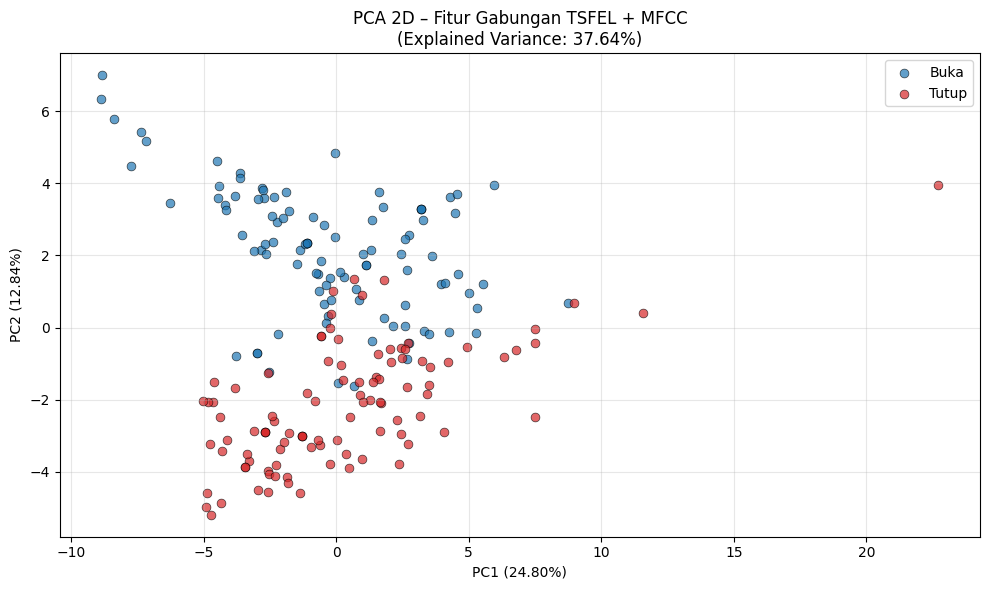


✅ Fitur gabungan tersimpan.
📁 Lokasi file: voice_features_tsfel_mfcc.csv
📊 Total sampel: 200
⚙️  Total fitur (tanpa label & filename): 58
📈 Explained variance PCA total: 37.64%


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================================
# PCA VISUALISASI FITUR GABUNGAN (TSFEL + MFCC)
# ==========================================================

# Pastikan DataFrame berasal dari hasil gabungan TSFEL + MFCC
X_clean = X_clean.dropna(subset=['label']).reset_index(drop=True)

# Pisahkan fitur dan label
X_for_scaling = X_clean.drop(columns=['label', 'filename']).values
y_for_viz = X_clean['label'].values

# --- 🔧 Imputasi nilai NaN ---
imputer = SimpleImputer(strategy='median')  # alternatif: 'mean'
X_imputed = imputer.fit_transform(X_for_scaling)

# --- Standarisasi fitur ---
scaler = StandardScaler()
Z = scaler.fit_transform(X_imputed)

# --- PCA ke 2 dimensi ---
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

# --- Visualisasi hasil PCA ---
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:red']
labels_name = ['Buka', 'Tutup']

for i, name in enumerate(labels_name):
    mask = (y_for_viz == i) if np.issubdtype(y_for_viz.dtype, np.number) else (y_for_viz == name)
    plt.scatter(Z2[mask, 0], Z2[mask, 1],
                s=40, alpha=0.7, c=colors[i],
                label=name, edgecolors='k', linewidth=0.5)

plt.title(f"PCA 2D – Fitur Gabungan TSFEL + MFCC\n(Explained Variance: {pca.explained_variance_ratio_.sum():.2%})")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Simpan hasil ke CSV ---
out_csv = "voice_features_tsfel_mfcc.csv"
X_clean.to_csv(out_csv, index=False)

print("\n✅ Fitur gabungan tersimpan.")
print(f"📁 Lokasi file: {out_csv}")
print(f"📊 Total sampel: {len(X_clean)}")
print(f"⚙️  Total fitur (tanpa label & filename): {X_clean.shape[1] - 2}")
print(f"📈 Explained variance PCA total: {pca.explained_variance_ratio_.sum():.2%}")


## 7) Klasifikasi dengan berbagai algoritma

Kita akan menguji beberapa model klasifikasi untuk membedakan suara "buka" dan "tutup".

In [10]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================================
# 🔹 KONFIGURASI UMUM
# ==========================================================
TARGET_SR = 16000
FEATURE_FILE = "voice_features_tsfel_mfcc.csv"
ARTIFACT_DIR = "artifacts"

# ==========================================================
# 🔹 LOAD DATASET FITUR
# ==========================================================
print("📂 Loading feature dataset...")

assert os.path.exists(FEATURE_FILE), f"File fitur tidak ditemukan: {FEATURE_FILE}"
df = pd.read_csv(FEATURE_FILE)

assert "label" in df.columns, "Kolom 'label' tidak ditemukan!"
assert "filename" in df.columns, "Kolom 'filename' tidak ditemukan!"

# Pisahkan fitur dan label
X = df.drop(columns=["label", "filename"])
y = df["label"]

print(f"✅ Dataset loaded: {X.shape}")
print(f"🔸 Total features digunakan untuk training: {X.shape[1]}")
print(f"   Contoh fitur: {list(X.columns[:5])}")

# ==========================================================
# 🔹 SPLIT DATA TRAIN & TEST
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\n📊 Data split -> Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================================================
# 🔹 SCALING FITUR
# ==========================================================
print("\n⚙️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Feature scaling completed.")

# ==========================================================
# 🔹 TRAINING RANDOM FOREST
# ==========================================================
print("\n🌳 Training RandomForestClassifier...")
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train_scaled, y_train)

# ==========================================================
# 🔹 EVALUASI MODEL
# ==========================================================
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

train_score = accuracy_score(y_train, train_pred)
test_score = accuracy_score(y_test, test_pred)

print(f"\n✅ Training accuracy : {train_score:.4f}")
print(f"✅ Test accuracy     : {test_score:.4f}\n")

print("📈 Classification Report:")
print(classification_report(y_test, test_pred))

# (Opsional) Top 10 fitur terpenting
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)
print("\n🔍 10 Fitur Terpenting:")
print(top_features)

# ==========================================================
# 🔹 SIMPAN ARTIFACTS
# ==========================================================
print("\n💾 Saving model artifacts...")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Model & scaler
joblib.dump(model, f"{ARTIFACT_DIR}/voice_classifier_model.pkl")
joblib.dump(scaler, f"{ARTIFACT_DIR}/voice_scaler.pkl")

# Nama fitur
feature_names = list(X.columns)
joblib.dump(feature_names, f"{ARTIFACT_DIR}/feature_names.pkl")

# Simpan konfigurasi TSFEL jika ada
if os.path.exists("tsfel_config.pkl"):
    cfg = joblib.load("tsfel_config.pkl")
    joblib.dump(cfg, f"{ARTIFACT_DIR}/tsfel_config.pkl")

print(f"✓ Model, scaler, dan fitur tersimpan di folder: '{ARTIFACT_DIR}/'")

# ==========================================================
# 🔹 SIMPAN METADATA
# ==========================================================
metadata = {
    "target_sr": TARGET_SR,
    "n_features": len(feature_names),
    "train_accuracy": float(train_score),
    "test_accuracy": float(test_score),
    "label_map": {0: "Buka", 1: "Tutup"},
    "feature_source": ["TSFEL", "MFCC"],
    "top_features": top_features.to_dict(),
}

joblib.dump(metadata, f"{ARTIFACT_DIR}/model_metadata.pkl")
with open(f"{ARTIFACT_DIR}/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✓ Metadata saved (model_metadata.pkl & model_metadata.json)")

print("\n" + "=" * 60)
print("✅ All artifacts saved successfully in folder 'artifacts/'")
print("=" * 60)


📂 Loading feature dataset...
✅ Dataset loaded: (200, 58)
🔸 Total features digunakan untuk training: 58
   Contoh fitur: ['0_Absolute energy', '0_Average power', '0_ECDF Percentile_0', '0_ECDF Percentile_1', '0_Entropy']

📊 Data split -> Train: (160, 58), Test: (40, 58)

⚙️ Scaling features...
✓ Feature scaling completed.

🌳 Training RandomForestClassifier...

✅ Training accuracy : 1.0000
✅ Test accuracy     : 1.0000

📈 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


🔍 10 Fitur Terpenting:
mfcc_mean_10         0.105691
mfcc_std_3           0.105144
mfcc_mean_5          0.094488
mfcc_mean_11         0.065327
mfcc_delta_mean_6    0.061958
mfcc_mean_4          0.058707
mfcc_mean_6          0.

In [69]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import librosa
import librosa.display
import tsfel
import joblib
import soundfile as sf
import tempfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
from audio_recorder_streamlit import audio_recorder

# ==========================================================
# 🎛️ Konfigurasi halaman
# ==========================================================
st.set_page_config(
    page_title="Klasifikasi Suara Buka/Tutup",
    page_icon="🎙️",
    layout="wide"
)

# ==========================================================
# 📦 Load model dan artefak
# ==========================================================
@st.cache_resource
def load_model_artifacts():
    model = joblib.load('artifacts/voice_classifier_model.pkl')
    scaler = joblib.load('artifacts/voice_scaler.pkl')
    feature_names = joblib.load('artifacts/feature_names.pkl')
    metadata = joblib.load('artifacts/model_metadata.pkl')
    cfg = tsfel.get_features_by_domain(["statistical"])
    return model, scaler, feature_names, metadata, cfg

# ==========================================================
# 🎚️ Preprocessing audio
# ==========================================================
def preprocess_audio(y, sr, target_sr=16000):
    """Resample, trim, dan normalisasi audio"""
    if y is None or len(y) == 0:
        raise ValueError("File audio kosong atau tidak terbaca.")

    # Resample jika perlu
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Trim (hapus bagian diam)
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)

    # Normalisasi amplitudo
    if len(y_trimmed) > 0 and np.max(np.abs(y_trimmed)) > 0:
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))

    if len(y_trimmed) < sr * 0.1:
        raise ValueError("Audio terlalu pendek setelah trimming.")

    return y_trimmed, sr

# ==========================================================
# 🔍 Ekstraksi fitur gabungan (TSFEL + MFCC)
# ==========================================================
def extract_combined_features(y, sr, feature_names, cfg):
    """Ekstraksi fitur gabungan TSFEL + MFCC"""
    try:
        if y is None or len(y) < 2048:
            raise ValueError(f"Audio terlalu pendek (len={len(y)})")

        # --- TSFEL (statistical domain) ---
        X_tsfel = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)
        if X_tsfel.shape[0] == 0:
            raise ValueError("Hasil ekstraksi TSFEL kosong.")
        tsfel_feats = X_tsfel.iloc[0].values

        # --- MFCC ringkas ---
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_feats = np.concatenate([mfcc_mean, mfcc_std])

        # --- Gabungkan ---
        all_features = np.concatenate([tsfel_feats, mfcc_feats])

        # Samakan panjang
        if len(all_features) != len(feature_names):
            diff = len(feature_names) - len(all_features)
            if diff > 0:
                all_features = np.append(all_features, np.zeros(diff))
            else:
                all_features = all_features[:len(feature_names)]

        return all_features.reshape(1, -1)

    except Exception as e:
        st.error(f"⚠️ Error ekstraksi fitur: {e}")
        return None

# ==========================================================
# 🧠 Prediksi
# ==========================================================
def predict_audio(y, sr, model, scaler, feature_names, metadata, cfg):
    try:
        y_proc, sr_proc = preprocess_audio(y, sr, metadata["target_sr"])

        if len(y_proc) < 2048:
            st.error("⚠️ Audio terlalu pendek setelah preprocessing.")
            return None, None, None

        features = extract_combined_features(y_proc, sr_proc, feature_names, cfg)
        if features is None:
            return None, None, None

        if np.isnan(features).any():
            features = np.nan_to_num(features)

        features_df = pd.DataFrame(features, columns=feature_names)
        features_scaled = scaler.transform(features_df)
        prediction = model.predict(features_scaled)[0]
        probabilities = model.predict_proba(features_scaled)[0]

        return prediction, probabilities, y_proc
    except Exception as e:
        st.error(f"❌ Error prediksi: {e}")
        return None, None, None

# ==========================================================
# 🎧 Visualisasi audio
# ==========================================================
def plot_waveform_and_spectrogram(y, sr):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color='royalblue')
    axes[0].set_title("Waveform")
    axes[0].set_xlabel("Waktu (detik)")
    axes[0].set_ylabel("Amplitudo")
    axes[0].grid(alpha=0.3)

    S = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=sr, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1], cmap='magma')
    axes[1].set_title("Spectrogram (dB)")
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    plt.tight_layout()
    return fig

# ==========================================================
# 🚀 Main App
# ==========================================================
def main():
    st.title("🎙️ Klasifikasi Suara Buka/Tutup")
    st.markdown("""
    Aplikasi ini mengklasifikasikan suara menjadi **Buka** atau **Tutup** 
    menggunakan model Machine Learning berbasis **TSFEL + MFCC + Random Forest**.
    """)

    with st.spinner("🔄 Memuat model..."):
        model, scaler, feature_names, metadata, cfg = load_model_artifacts()

    # Sidebar informasi
    st.sidebar.header("📊 Informasi Model")
    st.sidebar.write(f"**Akurasi Training:** {metadata['train_accuracy']:.2%}")
    st.sidebar.write(f"**Akurasi Testing:** {metadata['test_accuracy']:.2%}")
    st.sidebar.write(f"**Jumlah Fitur:** {metadata['n_features']}")
    st.sidebar.write(f"**Sample Rate:** {metadata['target_sr']} Hz")
    st.sidebar.markdown("---")
    st.sidebar.header("ℹ️ Petunjuk")
    st.sidebar.markdown("""
    1. Rekam atau upload suara (.wav / .mp3)  
    2. Klik **Prediksi**  
    3. Lihat hasil dan visualisasi  
    """)

    st.subheader("🎤 Rekam atau Upload Suara")

    option = st.radio("Pilih sumber audio:", ["🎙️ Rekam Langsung", "📁 Upload File"])
    audio_data, sr = None, None

    if option == "🎙️ Rekam Langsung":
        audio_bytes = audio_recorder(
            text="Klik untuk mulai/stop rekam",
            recording_color="#e74c3c",
            neutral_color="#3498db",
            icon_size="2x"
        )
        if audio_bytes:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                tmp.write(audio_bytes)
                tmp_path = tmp.name
            try:
                y, sr = librosa.load(tmp_path, sr=None, mono=True)
                st.audio(audio_bytes, format="audio/wav")
                audio_data = y
            finally:
                os.remove(tmp_path)

    else:
        uploaded_file = st.file_uploader("📁 Upload file audio", type=["wav", "mp3"])
        if uploaded_file is not None:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                tmp.write(uploaded_file.read())
                tmp_path = tmp.name
            try:
                y, sr = librosa.load(tmp_path, sr=None, mono=True)
                st.audio(uploaded_file, format="audio/wav")
                audio_data = y
            finally:
                os.remove(tmp_path)

    # ==========================================
    # 🔍 Tombol Prediksi
    # ==========================================
    if audio_data is not None and sr is not None:
        durasi = len(audio_data) / sr
        st.info(f"Durasi audio: **{durasi:.2f} detik**  |  Sample rate: **{sr} Hz**")

        if len(audio_data) < 2048:
            st.error("⚠️ Audio terlalu pendek. Mohon rekam ulang minimal 0.5 detik.")
        elif st.button("🔍 Prediksi"):
            with st.spinner("🔎 Memproses dan memprediksi..."):
                pred, prob, y_proc = predict_audio(audio_data, sr, model, scaler, feature_names, metadata, cfg)
                if pred is not None:
                    label = metadata["label_map"][pred]
                    confidence = prob[pred] * 100
                    st.success(f"**Prediksi:** {label} ({confidence:.2f}%)")

                    st.markdown("#### Probabilitas:")
                    for i, name in metadata["label_map"].items():
                        st.write(f"{name}: {prob[i]*100:.2f}%")
                        st.progress(prob[i])

                    fig = plot_waveform_and_spectrogram(y_proc, metadata["target_sr"])
                    st.pyplot(fig)

if __name__ == "__main__":
    main()


Overwriting app.py


In [11]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import librosa
import librosa.display
import tsfel
import joblib
import tempfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
from pydub import AudioSegment  # ✅ untuk membaca mp3
import soundfile as sf

# ==========================================================
# 🎛️ Konfigurasi halaman
# ==========================================================
st.set_page_config(
    page_title="Klasifikasi Suara Buka/Tutup",
    page_icon="🎙️",
    layout="wide"
)

# ==========================================================
# 📦 Load model dan artefak
# ==========================================================
@st.cache_resource
def load_model_artifacts():
    model = joblib.load('artifacts/voice_classifier_model.pkl')
    scaler = joblib.load('artifacts/voice_scaler.pkl')
    feature_names = joblib.load('artifacts/feature_names.pkl')
    metadata = joblib.load('artifacts/model_metadata.pkl')
    return model, scaler, feature_names, metadata


# ==========================================================
# 🎚️ Preprocessing audio
# ==========================================================
def preprocess_audio(y, sr, target_sr=16000):
    """Resample, trim, dan normalisasi audio"""
    if y is None or len(y) == 0:
        raise ValueError("File audio kosong atau tidak terbaca.")
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)
    if np.max(np.abs(y_trimmed)) > 0:
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))
    if len(y_trimmed) < sr * 0.1:
        raise ValueError("Audio terlalu pendek setelah trimming.")
    return y_trimmed, sr


# ==========================================================
# 🔍 Ekstraksi fitur (TSFEL + MFCC)
# ==========================================================
def extract_mfcc_features(y, sr, n_mfcc=13):
    """Ekstrak fitur MFCC: mean, std, delta mean"""
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
    return np.hstack([mfcc_mean, mfcc_std, mfcc_delta_mean])


def extract_combined_features(y, sr, feature_names):
    """Ekstraksi fitur gabungan TSFEL + MFCC"""
    try:
        cfg = tsfel.get_features_by_domain(["statistical"])
        X_tsfel = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)
        tsfel_feats = X_tsfel.iloc[0].values
        mfcc_feats = extract_mfcc_features(y, sr)
        all_features = np.concatenate([tsfel_feats, mfcc_feats])

        # Sesuaikan panjangnya agar sama dengan feature_names
        diff = len(feature_names) - len(all_features)
        if diff > 0:
            all_features = np.append(all_features, np.zeros(diff))
        elif diff < 0:
            all_features = all_features[:len(feature_names)]

        return all_features.reshape(1, -1)
    except Exception as e:
        st.error(f"⚠️ Error saat ekstraksi fitur: {str(e)}")
        return None


# ==========================================================
# 🧠 Prediksi
# ==========================================================
def predict_audio(y, sr, model, scaler, feature_names, metadata):
    """Prediksi kelas audio"""
    y_proc, sr_proc = preprocess_audio(y, sr, metadata["target_sr"])
    features = extract_combined_features(y_proc, sr_proc, feature_names)
    if features is None:
        return None, None, None

    if np.isnan(features).any():
        st.warning("Beberapa fitur mengandung NaN. Nilai diganti dengan 0.")
        features = np.nan_to_num(features)

    features_df = pd.DataFrame(features, columns=feature_names)
    features_scaled = scaler.transform(features_df)
    prediction = model.predict(features_scaled)[0]
    probabilities = model.predict_proba(features_scaled)[0]

    return prediction, probabilities, y_proc


# ==========================================================
# 🎧 Visualisasi audio
# ==========================================================
def plot_waveform_and_spectrogram(y, sr):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color='royalblue')
    axes[0].set_title("Waveform")
    axes[0].set_xlabel("Waktu (detik)")
    axes[0].set_ylabel("Amplitudo")
    axes[0].grid(alpha=0.3)

    S = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=sr, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1], cmap='magma')
    axes[1].set_title("Spectrogram (dB)")
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    plt.tight_layout()
    return fig


# ==========================================================
# 🚀 Main App
# ==========================================================
def main():
    st.title("🎙️ Klasifikasi Suara Buka/Tutup")
    st.markdown("""
    Aplikasi ini mengklasifikasikan suara menjadi **Buka** atau **Tutup** 
    menggunakan model Machine Learning berbasis **TSFEL + MFCC + Random Forest**.
    """)

    with st.spinner("🔄 Memuat model..."):
        model, scaler, feature_names, metadata = load_model_artifacts()

    # Sidebar info
    st.sidebar.header("📊 Informasi Model")
    st.sidebar.write(f"**Akurasi Training:** {metadata['train_accuracy']:.2%}")
    st.sidebar.write(f"**Akurasi Testing:** {metadata['test_accuracy']:.2%}")
    st.sidebar.write(f"**Jumlah Fitur:** {metadata['n_features']}")
    st.sidebar.write(f"**Sample Rate:** {metadata['target_sr']} Hz")
    st.sidebar.markdown("---")
    st.sidebar.info("Upload file .wav atau .mp3, lalu klik **Prediksi**.")

    # Upload file
    uploaded_file = st.file_uploader("📁 Upload file audio", type=["wav", "mp3", "m4a"])

    if uploaded_file is not None:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
            tmp_path = tmp.name
            # ✅ Konversi otomatis semua format ke .wav
            raw_bytes = uploaded_file.read()
            audio = AudioSegment.from_file(BytesIO(raw_bytes))
            audio.export(tmp_path, format="wav")

        try:
            y, sr = librosa.load(tmp_path, sr=None, mono=True)
            st.audio(raw_bytes, format="audio/wav")

            st.metric("Durasi", f"{len(y)/sr:.2f} detik")
            st.metric("Sample Rate", f"{sr} Hz")

            if st.button("🔍 Prediksi"):
                with st.spinner("Memprediksi..."):
                    pred, prob, y_proc = predict_audio(y, sr, model, scaler, feature_names, metadata)
                    if pred is not None:
                        label = metadata["label_map"][pred]
                        confidence = prob[pred] * 100
                        st.success(f"**Prediksi:** {label} ({confidence:.2f}%)")

                        st.markdown("#### Probabilitas:")
                        for i, name in metadata["label_map"].items():
                            st.write(f"{name}: {prob[i]*100:.2f}%")
                            st.progress(prob[i])

                        fig = plot_waveform_and_spectrogram(y_proc, metadata["target_sr"])
                        st.pyplot(fig)
        finally:
            os.remove(tmp_path)


if __name__ == "__main__":
    main()


Writing app.py


## 8) Analisis Feature Importance

Melihat fitur mana yang paling penting dalam membedakan suara "buka" dan "tutup" menggunakan Random Forest.

🔝 Top 20 Fitur Terpenting:


,feature,importance
28,mfcc_mean_10,0.105691
34,mfcc_std_3,0.105144
23,mfcc_mean_5,0.094488
29,mfcc_mean_11,0.065327
50,mfcc_delta_mean_6,0.061958
22,mfcc_mean_4,0.058707
24,mfcc_mean_6,0.056548
21,mfcc_mean_3,0.039498
30,mfcc_mean_12,0.033616
35,mfcc_std_4,0.033386


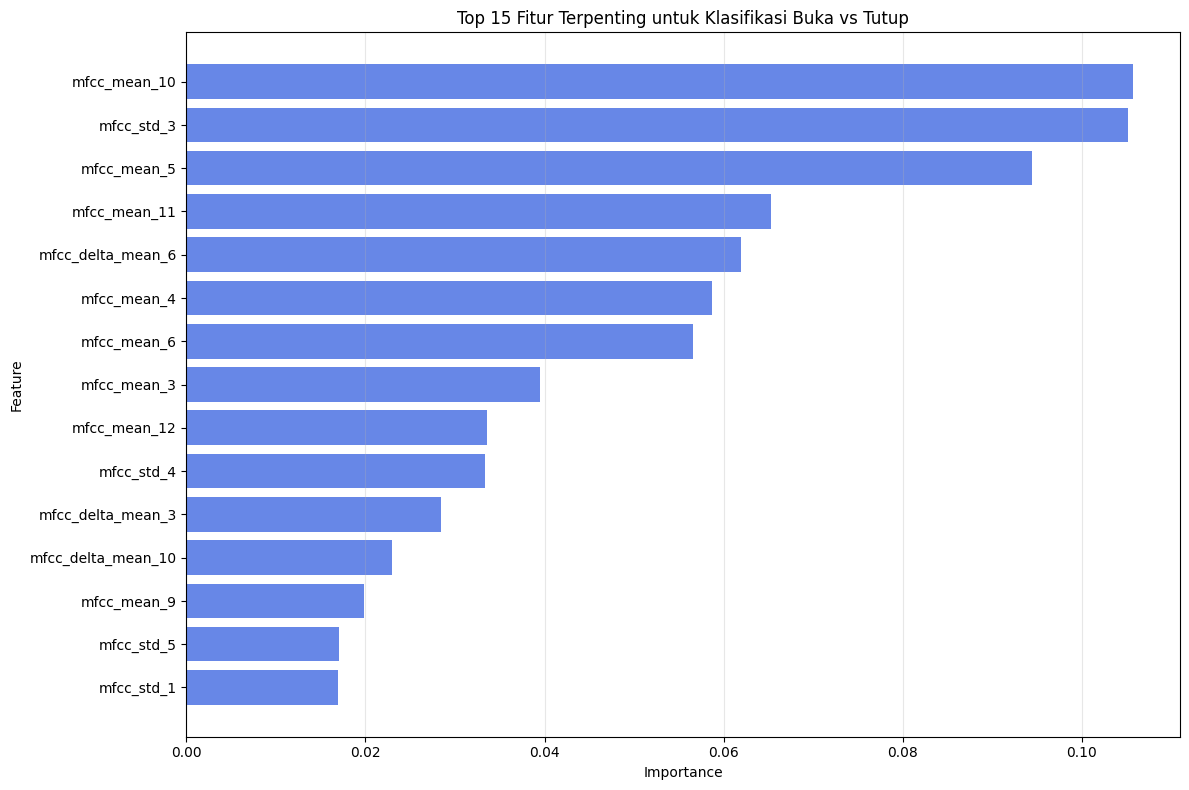


📊 Statistik Deskriptif untuk Top 5 Fitur:

mfcc_mean_10:
  Buka  - Mean: 1.3408, Std: 6.3681, Min: -15.0635, Max: 18.3898
  Tutup - Mean: -14.6773, Std: 10.6900, Min: -33.8784, Max: 17.0130

mfcc_std_3:
  Buka  - Mean: 22.2561, Std: 6.4364, Min: 9.9855, Max: 34.0467
  Tutup - Mean: 12.0384, Std: 3.7434, Min: 5.6401, Max: 25.5680

mfcc_mean_5:
  Buka  - Mean: -13.4233, Std: 6.7204, Min: -26.0342, Max: 3.5099
  Tutup - Mean: 1.6260, Std: 7.9410, Min: -17.3294, Max: 17.7843

mfcc_mean_11:
  Buka  - Mean: -4.5038, Std: 5.9910, Min: -20.7649, Max: 7.1173
  Tutup - Mean: -15.5543, Std: 7.5284, Min: -28.5318, Max: 1.0045

mfcc_delta_mean_6:
  Buka  - Mean: 0.5080, Std: 0.5536, Min: -0.3302, Max: 1.8807
  Tutup - Mean: -0.0632, Std: 0.2671, Min: -1.2976, Max: 0.8863


In [12]:
# ==========================================================
# 🔍 Analisis Feature Importance Random Forest
# ==========================================================
import matplotlib.pyplot as plt
import pandas as pd

# Ambil feature importance dari model RandomForest yang sudah kamu latih
rf_model = model  # ✅ langsung gunakan model kamu sebelumnya
feature_importance = rf_model.feature_importances_

# Ambil nama fitur dari dataset bersih
feature_names_clean = X_clean.drop(columns=['label', 'filename']).columns

# Buat DataFrame untuk ranking
importance_df = pd.DataFrame({
    'feature': feature_names_clean,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Tampilkan top 20 fitur
print("🔝 Top 20 Fitur Terpenting:")
display(importance_df.head(20))

# ==========================================================
# 📊 Visualisasi Top 15 Feature Importance
# ==========================================================
plt.figure(figsize=(12, 8))
top_n = 15
top_features = importance_df.head(top_n)
plt.barh(top_features['feature'], top_features['importance'], color='royalblue', alpha=0.8)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Fitur Terpenting untuk Klasifikasi Buka vs Tutup')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# ==========================================================
# 📈 Statistik Deskriptif untuk Top 5 Fitur
# ==========================================================
print("\n📊 Statistik Deskriptif untuk Top 5 Fitur:")
top_5_features = importance_df.head(5)['feature'].values
X_with_labels = X_clean.copy()

for feature in top_5_features:
    buka_vals = X_with_labels.loc[X_with_labels['label']==0, feature].dropna()
    tutup_vals = X_with_labels.loc[X_with_labels['label']==1, feature].dropna()

    print(f"\n{feature}:")
    print(f"  Buka  - Mean: {buka_vals.mean():.4f}, Std: {buka_vals.std():.4f}, Min: {buka_vals.min():.4f}, Max: {buka_vals.max():.4f}")
    print(f"  Tutup - Mean: {tutup_vals.mean():.4f}, Std: {tutup_vals.std():.4f}, Min: {tutup_vals.min():.4f}, Max: {tutup_vals.max():.4f}")
